In [165]:
import numpy as np
import os
import pandas as pd 
import seaborn as sb
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import logit, expit

In [136]:
#pd.read_csv("")
os.listdir("../../results/DMS")
full_df = pd.read_csv("../../results/DMS/dms_curated.csv")

In [137]:
full_df.describe()

,-log(Kd),E,NLL,-log(IC50)
count,199992.000000,3.331000e+06,3.331000e+06,20.000000
mean,7.078539,7.340409e-01,1.025442e+00,1.566273
std,1.480310,4.250668e-01,3.572940e-01,1.049558
min,6.000000,0.000000e+00,1.811566e-05,-0.240553
25%,6.000000,2.600524e-01,1.000000e+00,0.574764
50%,6.000000,1.000000e+00,1.000000e+00,1.987922
75%,8.766032,1.000000e+00,1.000000e+00,2.485710
max,10.318759,1.000000e+00,4.661899e+00,2.903136


In [16]:
different_pubs = list(set(full_df.publication))

In [17]:
full_df.head()

,publication,antibody,mutation_code,antigen,-log(Kd),E,NLL,-log(IC50)
0,phillips21_bindin,cr6261,SD167R;ND196K;KD211D;SD214G;AD216V;LD241V,h1newcal99,9.444671,NaN,NaN,NaN
1,phillips21_bindin,cr6261,SD167R;ND196K;QD199P;KD211D;SD212F;AD216V;LD241V,h1newcal99,9.429218,NaN,NaN,NaN
2,phillips21_bindin,cr6261,SD167R;ND196K;KD211D;SD214G;LD241V,h1newcal99,9.099022,NaN,NaN,NaN
3,phillips21_bindin,cr6261,SD167R;KD211D;SD214G;AD216V,h1newcal99,9.322949,NaN,NaN,NaN
4,phillips21_bindin,cr6261,SD167R;QD199P;KD211D;AD216V,h1newcal99,8.612018,NaN,NaN,NaN


In [25]:
df_1 = full_df[full_df.publication==different_pubs[0]] # set(full_df.antigen), set(full_df.antibody)

<AxesSubplot:xlabel='-log(Kd)', ylabel='E'>

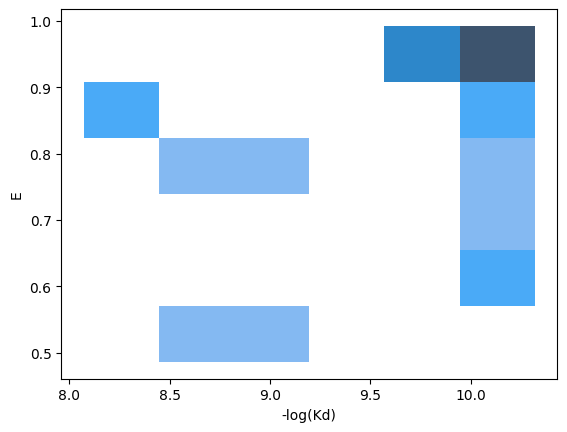

In [30]:
sb.histplot(df_1, x="-log(Kd)", y="E")

madan21_mutat_hiv
phillips21_bindin


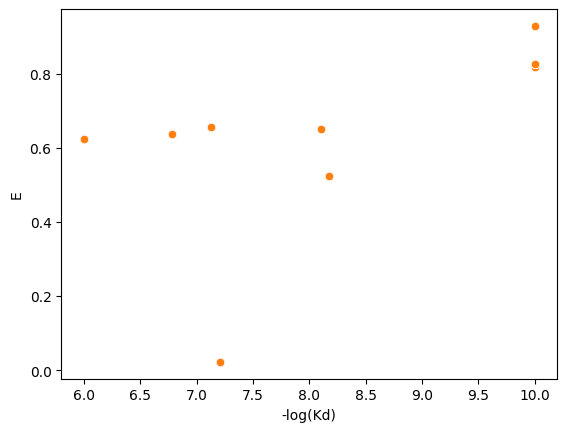

In [95]:
for pub in different_pubs[:2]:
    df = full_df[full_df.publication=="wu20_differ_ha_h3_h1"]
    print(pub, )
    try:
        sb.scatterplot(data=df, x="-log(Kd)", y="E")
        plt.show()
        plt.close("all")
    except:
        pass

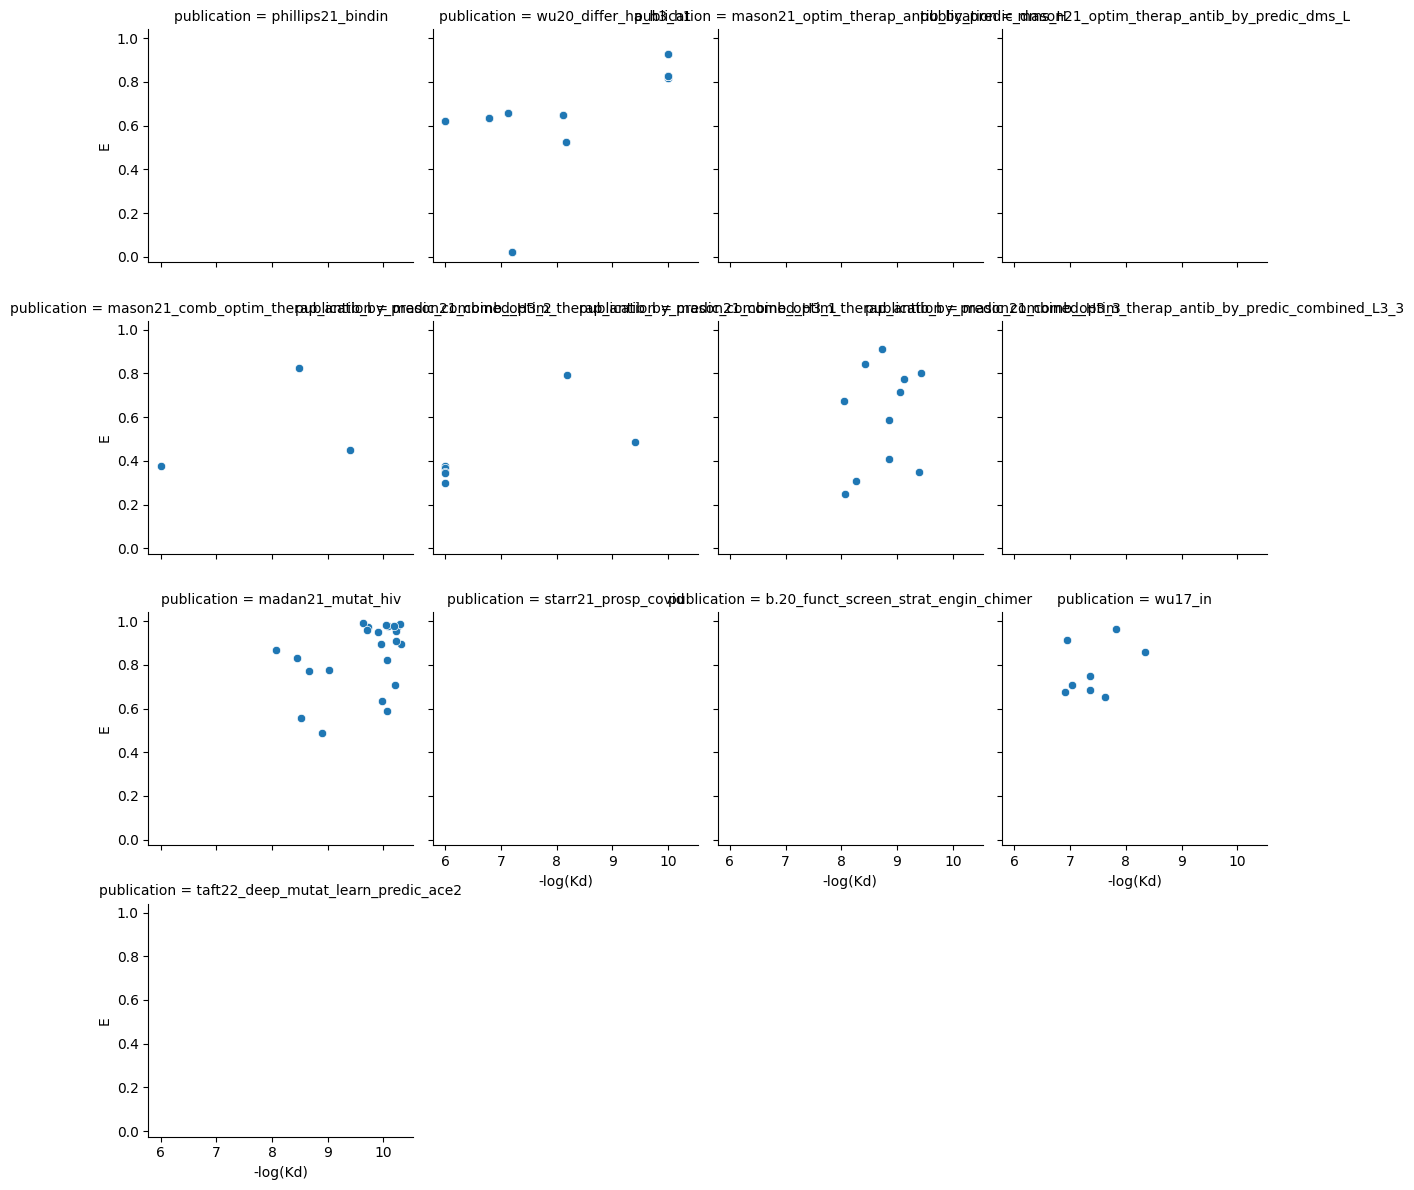

In [49]:
g = sb.FacetGrid(full_df, col="publication",col_wrap=4,)
g.map(sb.scatterplot, "-log(Kd)", "E")


In [167]:
def fit_regression(df, name ,sigmoid=False):
    model = LinearRegression()
    x_values = (df["-log(Kd)"].values.reshape(-1,1)-5)/9
    if sigmoid:
        y_values =logit(df["E"].values)
    else:
        y_values = df["E"].values
    model.fit(x_values,y_values)
    #sb.regplot(data=df, x="-log(Kd)", y="E")
    sb.regplot(x=x_values, y=y_values)
    #plt.show()
    #model_bias_free = LinearRegression(fit_intercept=False)
    #model_bias_free.fit((filterd_df["-log(Kd)"].values.reshape(-1,1)-5)/9,filterd_df["E"].values)
    
    y_hat = model.predict(x_values)
    if sigmoid:
        y_hat = expit(y_hat)
    
    print(name,len(df), model.coef_ , model.intercept_, model.score(x_values,y_values))
    mse = np.mean((y_hat-df["E"].values)**2)
    print("MSE:", mse)
    return model, mse


madan21_mutat_hiv 23 [0.82824544] 0.41644568799226406 0.1700256016013746
MSE: 0.018998451900434376
mason21_comb_optim_therap_antib_by_predic_combined_H3_3 11 [1.08293388] 0.1493535863888128 0.06359289774916199
MSE: 0.047290624107497736
wu17_in 8 [0.74611165] 0.5749515719406949 0.11742173762692809
MSE: 0.010994101562308109
mason21_comb_optim_therap_antib_by_predic_combined_H3_2 3 [0.49509498] 0.3880937320273913 0.15962370124246394
MSE: 0.032804530814355005
mason21_comb_optim_therap_antib_by_predic_combined_H3_1 7 [0.74439473] 0.28162449514249066 0.46636048890339277
MSE: 0.013275541214165274
wu20_differ_ha_h3_h1 48 [0.91228113] 0.31676705347051387 0.5126476486341425
MSE: 0.015401196328273054


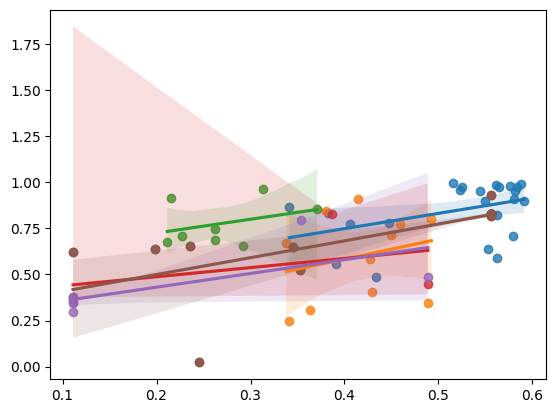

In [170]:

model_params = {}
errors  = []
for pub in different_pubs: #["madan21_mutat_hiv"]:["wu20_differ_ha_h3_h1"]:#
    df = full_df[full_df.publication==pub]
    filterd_df = df[~df["-log(Kd)"].isna()]
    filterd_df = filterd_df[~filterd_df["E"].isna()]
    if len(filterd_df)==0:
        #print(pub, "We do not have matching pairs")
        continue
    if False:
        for ab in set(filterd_df["antibody"].values):
            for ag in set(filterd_df["antigen"].values):
                df_sub = filterd_df[(filterd_df["antibody"]==ab) & (filterd_df["antigen"]==ag)]
                if len(df_sub)==0:
                    continue
                model = fit_regression(df_sub,f"{pub}:{ab}:{ag}")
                model_params[f"{pub}:{ab}:{ag}"] = (model.coef_[0],model.intercept_)

    model,mse = fit_regression(filterd_df, pub, False)
    model_params[f"{pub}"] = (model.coef_[0],model.intercept_)
    errors.append(mse)
    
    #print("Mean Score:", mean_model.score((filterd_df["-log(Kd)"].values.reshape(-1,1)-5)/9,filterd_df["E"].values)
#print(model_params)

In [169]:
errors

[0.0221088886848178,
 0.047638053400828655,
 0.012097492117329075,
 0.03280698723502587,
 0.013164591764737596,
 0.017282128709712193]

In [171]:
errors

[0.018998451900434376,
 0.047290624107497736,
 0.010994101562308109,
 0.032804530814355005,
 0.013275541214165274,
 0.015401196328273054]

In [72]:
model.coef_ , model.intercept_

(array([0.82824544]), 0.41644568799226406)

In [70]:
filterd_df1["-log(Kd)"].values

array([ 9.94692156, 10.31875876, 10.24949161, 10.22548303, 10.07572071,
       10.05060999, 10.29073004,  9.89962945,  9.7212464 , 10.2313619 ,
        8.52287875,  9.63827216,  9.02502801,  8.65757732,  8.07314329,
        8.44611697,  8.89962945, 10.18708664, 10.06048075, 10.21467016,
        9.70553377,  9.97469413, 10.06098022])

In [81]:
np.mean(weights), np.mean(biases)

(0.8015103005794898, 0.3545393544936946)

In [87]:
mean_model = LinearRegression()
mean_model.coef_ = np.asarray([np.mean(weights),])
mean_model.intercept_ = np.asarray( np.mean(biases))

In [85]:
mean_model.coef_

array([0.8015103])

In [116]:
filterd_df

,publication,antibody,mutation_code,antigen,-log(Kd),E,NLL,-log(IC50)
199924,wu20_differ_ha_h3_h1,cr9114,IB45F,h3hk68,6.000000,0.622914,0.5,NaN
199933,wu20_differ_ha_h3_h1,cr9114,IB45T,h3hk68,6.783043,0.636106,0.5,NaN
199965,wu20_differ_ha_h3_h1,cr9114,IB45M,h3hk68,7.124939,0.656367,0.5,NaN
199985,wu20_differ_ha_h3_h1,cr9114,NB49T,h3hk68,10.000000,0.928706,0.5,NaN
199990,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN
199991,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN
199992,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN
199993,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN
199994,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN
199995,wu20_differ_ha_h3_h1,cr9114,WT,h3hk68,10.000000,0.826610,0.5,NaN


In [123]:
model_params

{'madan21_mutat_hiv': (0.8282454412193105, 0.41644568799226406),
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_3': (1.0829338825283161,
  0.1493535863888128),
 'wu17_in': (0.746111647985783, 0.5749515719406949),
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_2': (0.49509497516218,
  0.3880937320273913),
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_1': (0.7443947282767032,
  0.28162449514249066),
 'wu20_differ_ha_h3_h1': (0.9122811283046462, 0.31676705347051387)}

In [126]:
for pub in different_pubs:
    df = full_df[full_df.publication==pub]
    print(pub,len(df[~df["-log(Kd)"].isna()].drop_duplicates()))

madan21_mutat_hiv 23
phillips21_bindin 199892
mason21_comb_optim_therap_antib_by_predic_combined_H3_3 11
wu17_in 8
b.20_funct_screen_strat_engin_chimer 0
mason21_optim_therap_antib_by_predic_dms_H 0
mason21_optim_therap_antib_by_predic_dms_L 0
starr21_prosp_covid 0
taft22_deep_mutat_learn_predic_ace2 0
mason21_comb_optim_therap_antib_by_predic_combined_H3_2 3
mason21_comb_optim_therap_antib_by_predic_combined_H3_1 7
wu20_differ_ha_h3_h1 10
mason21_comb_optim_therap_antib_by_predic_combined_L3_3 0


In [128]:
os.listdir("../../")
skempi = pd.read_csv("../../results/SKEMPI_v2/skempi_v2.csv")
bench = pd.read_csv("../../results/antibody_benchmark/benchmark.csv")
abag = pd.read_csv("../../results/abag_affinity_dataset/abag_affinity_dataset.csv")

In [130]:
skempi.describe()

,-log(Kd),validation
count,375.000000,87.000000
mean,7.584811,2.310345
std,1.506687,2.460433
min,3.504456,1.000000
25%,6.602060,1.000000
50%,7.522879,2.000000
75%,8.438899,2.000000
max,11.832683,12.000000


In [132]:
bench.describe()

,-log(Kd),Kd (nM),delta_g,validation
count,29.000000,29.000000,29.000000,29.0
mean,8.677694,194.013890,-11.921379,0.0
std,1.427323,871.059361,1.968434,0.0
min,5.327902,0.007000,-15.220000,0.0
25%,7.721246,0.180000,-13.490000,0.0
50%,8.657577,2.200000,-11.810000,0.0
75%,9.744727,19.000000,-10.920000,0.0
max,11.154902,4700.000000,-7.270000,0.0


In [133]:
abag.describe()

,-log(Kd),delta_g,validation
count,356.000000,353.000000,356.000000
mean,8.369452,-11.458623,2.157303
std,1.470743,1.974093,1.358532
min,3.795880,-16.056540,0.000000
25%,7.508638,-12.611243,1.000000
50%,8.328789,-11.440000,2.000000
75%,9.249995,-10.257147,3.000000
max,11.769551,-5.178507,4.000000


Full 100 [0.87047189] 0.34777069727887455 0.398123825389196


LinearRegression()

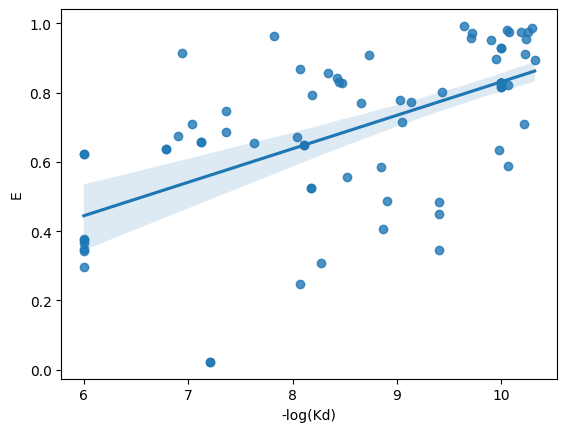

In [143]:
full_filtered_df = full_df[~full_df["-log(Kd)"].isna()]
full_filtered_df = full_filtered_df[~full_filtered_df["E"].isna()]
fit_regression(full_filtered_df,"Full")

In [142]:
filterd_df.describe()

,-log(Kd),E,NLL,-log(IC50)
count,100.000000,100.000000,100.000000,0.0
mean,8.963734,0.731139,0.553465,NaN
std,1.352333,0.207294,0.387810,NaN
min,6.000000,0.022543,0.069213,NaN
25%,8.107905,0.646341,0.286130,NaN
50%,9.810438,0.826610,0.500000,NaN
75%,10.000000,0.826610,0.500000,NaN
max,10.318759,0.992476,2.005809,NaN
